In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sys
!{sys.executable} -m pip install pandas-profiling
!{sys.executable} -m pip install pandasql 
from pandasql import sqldf
import pandas_profiling

###############################################################################################
# Process Clinical data
###############################################################################################

patient_data = pd.read_csv('patient_data.csv')
patient = pd.read_csv('patient_data.csv')

patient = patient.set_index('track_name').T
patient = patient[1:]
patient = patient.reset_index()
patient = patient.rename(columns = {'index':'ID'})

patient['ID'] = patient['ID'].str.upper()
patient['Diagnosis Age'] = pd.to_numeric(patient['Diagnosis Age'])
patient['Overall Survival (Months)'] = pd.to_numeric(patient['Overall Survival (Months)'])
patient['Mutation Count'] = pd.to_numeric(patient['Mutation Count'])
patient['Sex'] = patient['Sex'].str.lower()
patient = patient[patient['# Samples per Patient']!='2'].reset_index(drop=True)

def label(x):
    if 'T1' in x:
        return 'T1'
    if 'T2' in x:
        return 'T2'
    if 'T3' in x:
        return 'T3'
    return 'T4'
patient['Stage'] = patient['American Joint Committee on Cancer Tumor Stage Code'].apply(lambda x: label(x))

patient = patient.drop(['Profiled in Mutations','Profiled in Putative copy-number alterations from GISTIC','Patient\'s Vital Status','# Samples per Patient','Cancer Type','Informed consent verified','Neoplasm Histologic Type Name'],axis=1)

###############################################################################################
# Process Tumor mRNA gene expression data
###############################################################################################

mrna_data = pd.read_csv('mrna_data.txt',sep='\t')
mrna = pd.read_csv('mrna_data.txt',sep='\t')

mrna.dropna(thresh=1,axis=1,inplace=True)
mrna = mrna.drop(['STUDY_ID'],axis=1)

def id_process(x):
    new = x[:len(x)-3]
    new = new.replace("_","")
    return new.upper()
mrna['SAMPLE_ID'] = mrna['SAMPLE_ID'].apply(lambda x: id_process(x))

###############################################################################################
# Process Tumor Mutation Sequencing data
###############################################################################################

seq_data = pd.read_csv('seq_data.txt',sep='\t')
seq = pd.read_csv('seq_data.txt',sep='\t')

seq.dropna(how='all',axis=1,inplace=True)
seq = seq.drop(['STUDY_ID'],axis=1)
seq['SAMPLE_ID'] = seq['SAMPLE_ID'].apply(lambda x: id_process(x))
seq = pd.get_dummies(seq, columns=seq.iloc[:,1:].columns,dummy_na=False)


In [37]:
###############################################################################################
# Process combined dataframe
###############################################################################################

def pysqldf(q):
    return sqldf(q, globals())

q = '''
SELECT *
FROM patient
JOIN mrna
ON patient.ID = mrna.SAMPLE_ID
JOIN seq
ON patient.ID = seq.SAMPLE_ID
'''
df = pysqldf(q)



In [38]:
df

,ID,American Joint Committee on Cancer Tumor Stage Code,Diagnosis Age,Overall Survival (Months),Neoplasm Histologic Grade,Race Category,Overall Survival Status,Sex,Mutation Count,Stage,...,OR51B4_R124H,OR51B4_V247L,GALNT9_P147Lfs*25,KCNK3_G117D,PCDHB1_G428R,PCDHB1_P467L,PCDHB1_R79S,LRRTM3_L138F,LRRTM3_N233K,LRRTM3_N504K
0,CG-A3-3387,T1a,49,20.27,G2,WHITE,LIVING,male,70,T1,...,0,0,0,0,0,0,0,0,0,0
1,CG-A3-3374,T1b,51,43.17,G2,BLACK OR AFRICAN AMERICAN,LIVING,female,934,T1,...,0,0,0,0,0,0,0,0,0,0
2,CG-A3-3363,T2,50,10.48,G2,ASIAN,LIVING,male,1392,T2,...,0,0,0,0,0,0,0,0,0,0
3,CG-CZ-5460,T3b,55,94.38,G2,WHITE,LIVING,male,52,T3,...,0,0,0,0,0,0,0,0,0,0
4,CG-BP-4176,T1b,64,64.22,G2,WHITE,LIVING,male,85,T1,...,0,0,0,0,0,0,0,0,0,0
5,CG-CJ-6032,T2,63,119.55,G3,WHITE,LIVING,female,42,T2,...,0,0,0,0,0,0,0,0,0,0
6,CG-BP-5192,T1a,59,23.46,G2,WHITE,LIVING,male,46,T1,...,0,0,0,0,0,0,0,0,0,0
7,CG-CW-5585,T3b,51,85.71,G2,WHITE,LIVING,male,41,T3,...,0,0,0,0,0,0,0,0,0,0
8,CG-B0-5691,T1a,66,112.71,G3,WHITE,LIVING,female,55,T1,...,0,0,0,0,0,0,0,0,0,0
9,CG-AK-3453,T2,58,83.15,G2,WHITE,LIVING,female,350,T2,...,0,0,0,0,0,0,0,0,0,0


In [39]:
df = df.drop(['SAMPLE_ID'],axis=1)

In [40]:
df.to_csv ('df.csv')

In [41]:
col_with_null = df.loc[:,df.isnull().sum(axis=0)>0]
nulls = col_with_null[col_with_null.isnull().any(axis=1)]
ind = nulls.index

df.iloc[ind,4:6]

,Neoplasm Histologic Grade,Race Category
30,G2,None
64,None,BLACK OR AFRICAN AMERICAN
88,G2,None
158,G3,None
179,G2,None
196,None,BLACK OR AFRICAN AMERICAN
275,None,WHITE
276,G2,None
349,G3,None
483,G2,None


In [42]:
from sklearn.neighbors import KNeighborsClassifier

In [43]:
fitting = df
fitting = fitting.iloc[:,:90]
fitting = fitting.drop(['ID','American Joint Committee on Cancer Tumor Stage Code','Overall Survival Status','Sex','Stage'],axis=1)

In [54]:
race_fit = fitting.drop(['Neoplasm Histologic Grade'],axis=1)
null_index = race_fit.isnull().any(axis=1)
row_with_null = race_fit[null_index]
row_no_null = race_fit[-null_index]

clf = KNeighborsClassifier(3, weights='distance')
x = row_no_null.drop(['Race Category'],axis=1)
y = row_no_null['Race Category']
clf.fit(x,y)
x_test = row_with_null.drop(['Race Category'],axis=1)
imputes = clf.predict(x_test)

df.loc[null_index,'Race Category'] = imputes 

/Users/yuchen/anaconda3/envs/ds_pack/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [55]:
grade_fit = fitting.drop(['Race Category'],axis=1)
null_index = grade_fit.isnull().any(axis=1)
row_with_null = grade_fit[null_index]
row_no_null = grade_fit[-null_index]

clf = KNeighborsClassifier(3, weights='distance')
x = row_no_null.drop(['Neoplasm Histologic Grade'],axis=1)
y = row_no_null['Neoplasm Histologic Grade']
clf.fit(x,y)
x_test = row_with_null.drop(['Neoplasm Histologic Grade'],axis=1)
imputes = clf.predict(x_test)

df.loc[null_index,'Neoplasm Histologic Grade'] = imputes 

/Users/yuchen/anaconda3/envs/ds_pack/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [56]:
df.iloc[ind,4:6]

,Neoplasm Histologic Grade,Race Category
30,G2,WHITE
64,G1,BLACK OR AFRICAN AMERICAN
88,G2,WHITE
158,G3,WHITE
179,G2,WHITE
196,G2,BLACK OR AFRICAN AMERICAN
275,G3,WHITE
276,G2,WHITE
349,G3,WHITE
483,G2,WHITE


In [57]:
fitting.iloc[ind,2:4]

,Neoplasm Histologic Grade,Race Category
30,G2,None
64,None,BLACK OR AFRICAN AMERICAN
88,G2,None
158,G3,None
179,G2,None
196,None,BLACK OR AFRICAN AMERICAN
275,None,WHITE
276,G2,None
349,G3,None
483,G2,None


In [58]:
fitting.isnull().sum().sum(axis=0)

10

In [59]:
df.isnull().sum().sum(axis=0)

0

In [92]:
df_temp = df
df_temp = df.drop(['ID','American Joint Committee on Cancer Tumor Stage Code'],axis=1)

In [93]:
x = df_temp.drop(['Overall Survival (Months)','Overall Survival Status'],axis=1)
x = pd.get_dummies(x, columns=['Sex','Race Category','Neoplasm Histologic Grade','Stage'])

In [94]:
y = df_temp[['Overall Survival (Months)','Overall Survival Status']]
y.loc[:,['Overall Survival Status']] = np.where(y['Overall Survival Status'] == 'LIVING',1,0)

/Users/yuchen/anaconda3/envs/ds_pack/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [95]:
survival_rate = y['Overall Survival Status'].sum()/y['Overall Survival Status'].shape[0]
survival_rate

0.6710526315789473

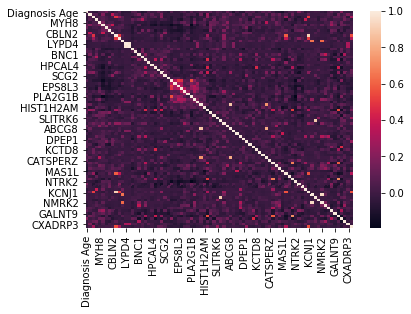

In [96]:
numeric_features = x.iloc[:,:82]
corr = numeric_features.corr()
sns.heatmap(corr)

In [97]:
y
# why there are some points with 0 Overall Survival (Months) but status is LIVING?

,Overall Survival (Months),Overall Survival Status
0,20.27,1
1,43.17,1
2,10.48,1
3,94.38,1
4,64.22,1
5,119.55,1
6,23.46,1
7,85.71,1
8,112.71,1
9,83.15,1


In [98]:
from sklearn import model_selection

# Reserve 20% for testing
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.2)

print('training data has %d observation with %d features'% x_train.shape)
print('test data has %d observation with %d features'% x_test.shape)

training data has 425 observation with 201 features
test data has 107 observation with 201 features


,Diagnosis Age,Mutation Count,CASR,BEX1,MYH8,SPON1,FABP4,SLITRK5,CBLN2,DGKK,...,NMRK2,GAL3ST3,MYMK,PLPPR5,GALNT9,UBE2QL1,KCNK3,PCDHB1,CXADRP3,LRRTM3
475,68,39,-0.1422,-0.3978,-0.3230,-0.5166,-0.3193,1.7197,-0.0352,-0.1788,...,-0.0833,-0.2239,-0.2581,1.9411,0.8395,0.4110,2.5683,-0.0433,-0.4425,0.2758
368,62,38,-0.3270,-0.3801,-0.3371,0.0926,-0.2023,-0.5553,-0.3020,-0.2532,...,-0.0834,-0.1198,-0.2581,-0.7091,0.2346,-0.2546,0.0675,-0.3519,-0.4425,-0.1675
170,41,0,-0.3270,-0.2782,-0.3319,-0.2078,-0.4125,-0.5832,-0.2548,-0.6173,...,-0.0834,-0.1534,0.2486,2.6224,-0.7703,-0.4202,0.8899,-0.0970,0.3836,-0.1691
267,72,17,0.1434,-0.3884,0.7342,-0.4666,-0.3134,-0.5570,-0.3020,-0.6173,...,-0.0833,-0.1503,-0.2581,-0.6928,-0.7349,-0.2333,0.0286,-0.2358,-0.0663,-0.4822
80,61,72,-0.2866,-0.3843,-0.3325,2.7338,0.0243,0.2524,0.9868,-0.6173,...,-0.0834,-0.2207,-0.2581,0.0644,-0.7263,-0.2596,0.7020,-0.3519,-0.0709,-0.4822
2,50,1392,-0.2440,-0.3324,0.4572,9.8551,-0.4222,-0.0040,16.2764,-0.6173,...,-0.0830,-0.0711,-0.2581,2.3981,-0.1062,-0.4213,-0.9130,0.6727,0.8858,-0.4822
196,61,0,-0.3229,0.0485,-0.3324,-0.6942,-0.3025,-0.5939,-0.2006,-0.6173,...,-0.0834,-0.2001,0.2082,-0.6410,0.1071,0.8045,-0.7809,0.2346,0.6979,-0.4822
397,60,34,0.0220,-0.3598,-0.1167,-0.4762,-0.3780,0.4087,-0.2545,-0.6173,...,-0.0834,-0.2223,0.1242,-0.7082,1.6174,-0.3272,-0.4702,-0.2557,-0.1309,-0.2460
167,69,26,-0.3150,-0.3971,-0.2756,-0.6867,-0.4007,-0.3173,-0.2739,-0.6173,...,-0.0833,-0.2010,0.1951,-0.6526,-0.6477,-0.0011,-0.9211,-0.2379,-0.4425,-0.4822
357,79,57,-0.3231,-0.3909,-0.3360,0.0804,-0.4122,-0.4565,-0.2746,1.5887,...,-0.0834,-0.2306,-0.2581,1.0206,-0.2827,-0.4141,-0.6997,-0.3519,-0.4425,-0.4822


In [105]:
# Scale the data, using standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train.iloc[:,:82] = scaler.fit_transform(x_train.iloc[:,:82])
x_test.iloc[:,:82] = scaler.transform(x_test.iloc[:,:82])

/Users/yuchen/anaconda3/envs/ds_pack/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/yuchen/anaconda3/envs/ds_pack/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/yuchen/anaconda3/envs/ds_pack/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/yuchen/anaconda3/envs/ds_pack/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input d